# ECE 689, Spring 2025
## Homework 3

## Full name:

## Question 1: Transformer for translation

Here, we implement transformers for neural machine translation (NMT), such as turning "Hello world" to "Salut le monde". You are going to follow the following steps:
1. Load and prepare the data. We provide "en-ft.txt". Each line of this file contains an English phrase, the equivalent French phrase, and an attribution identifying where the translation came from. The en-fr.txt used in problem 3 can also be found at: https://github.com/jeffprosise/Applied-Machine-Learning/tree/main/Chapter%2013/Data
2. Build and train a model. Implement a transformer from scratch in Pytorch. We will provide you with an existing implementation in Keras. You might also find https://github.com/gordicaleksa/pytorch-original-transformer useful.

For deliverables, plot your training and validation accuracy. The x-axis should be epoch, the y-axis should be your translation accuracy.

For reference, the provided code given at https://github.com/jeffprosise/Applied-Machine-Learning/blob/main/Chapter%2013/Neural%20Machine%20Translation%20(Transformer).ipynb achieves 85% accuracy after 14 epochs. You do not have to achieve the same performance to get full marks, just show understanding and functional codes.

In [1]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from bertviz import model_view

In [2]:
"""Clean the text by removing punctuation symbols and numbers, converting
characters to lowercase, and replacing Unicode characters with their ASCII
equivalents. For the French samples, insert [start] and [end] tokens at the
 beginning and end of each phrase"""
import pandas as pd
import re
from unicodedata import normalize

df = pd.read_csv('Data/en-fr.txt', names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

def clean_and_prepare_text(text):
    text = '[start] ' + clean_text(text) + ' [end]'
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_and_prepare_text(row))
df.head()

,en,fr
0,youre very clever,[start] vous etes fort ingenieuse [end]
1,are there kids,[start] y atil des enfants [end]
2,come in,[start] entrez [end]
3,wheres boston,[start] ou est boston [end]
4,you see what i mean,[start] vous voyez ce que je veux dire [end]


In [3]:
"""The next step is to scan the phrases and determine the maximum length of the
English phrases and then of the French phrases. These lengths will determine
the lengths of the sequences input to and output from the model"""
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)
sequence_len = max(en_max_len, fr_max_len)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')
print(f'Sequence length: {sequence_len}')

Max phrase length (English): 7
Max phrase length (French): 16
Sequence length: 16


In [4]:
import torch
from torchnlp.encoders.text import TreebankEncoder
from torchnlp.encoders.text import pad_tensor, stack_and_pad_tensors
from torchnlp.encoders.text import StaticTokenizerEncoder

def french_tokenize(text):
    text = text.replace('!', ' ').replace('"', ' ').replace('#', ' ') \
            .replace('$', ' ').replace('%', ' ').replace('&', ' ') \
            .replace('(', ' ').replace(')', ' ').replace('*', ' ') \
            .replace('+', ' ').replace(',', ' ').replace('-', ' ') \
            .replace('.', ' ').replace('/', ' ').replace(':', ' ') \
            .replace(';', ' ').replace('<', ' ').replace('=', ' ') \
            .replace('>', ' ').replace('?', ' ').replace('@', ' ') \
            .replace('\\', ' ').replace('^', ' ').replace('_', ' ') \
            .replace('`', ' ').replace('{', ' ').replace('|', ' ') \
            .replace('}', ' ').replace('~', ' ').replace('\t', ' ') \
            .replace('\n', ' ')
    return text.split()


def custom_pad_sequences(sequences, max_len, padding_value=0):
    padded_seqs = []
    for seq in sequences:
        if len(seq) < max_len:
            # Pad the sequence
            padded = torch.cat([seq, torch.tensor([padding_value] * (max_len - len(seq)), dtype=torch.long)])
        else:
            # Truncate if longer than max_len
            padded = seq[:max_len]
        padded_seqs.append(padded)
    return torch.stack(padded_seqs)


In [5]:
entokenizer = TreebankEncoder(en)
frtokenizer = StaticTokenizerEncoder(fr, tokenize=french_tokenize, append_eos=False, reserved_tokens=['<pad>'])


[nltk_data] Downloading package perluniprops to
[nltk_data]     /hpc/home/ma618/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /hpc/home/ma618/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


In [6]:
en_sequences = [torch.tensor(entokenizer.encode(sentence)) for sentence in en]
fr_sequences = [torch.tensor(frtokenizer.encode(sentence)) for sentence in fr]

/tmp/ipykernel_162488/1370978746.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  en_sequences = [torch.tensor(entokenizer.encode(sentence)) for sentence in en]
/tmp/ipykernel_162488/1370978746.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fr_sequences = [torch.tensor(frtokenizer.encode(sentence)) for sentence in fr]


In [7]:
# Pad the sequences to the desired length
en_x = custom_pad_sequences(en_sequences, sequence_len, padding_value=0)
fr_y = custom_pad_sequences(fr_sequences, sequence_len + 1, padding_value=0)

In [8]:
"""Compute the vocabulary sizes from the Tokenizer instances"""
en_vocab_size = len(entokenizer.vocab) + 1
fr_vocab_size = len(frtokenizer.vocab) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6038
Vocabulary size (French): 12198


In [9]:
"""Finally, create the features and the labels the model will be trained with.
The features are the padded English sequences and the padded French sequences
minus the [end] tokens. The labels are the padded French sequences minus the
[start] tokens. Package the features in a dictionary so they can be input to a
model that accepts multiple inputs."""
inputs = { 'encoder_input': en_x, 'decoder_input': fr_y[:, :-1] }
outputs = fr_y[:, 1:]

In [10]:
def decode_sequence(sequence, tokenizer):
    # Convert tensor to list if necessary
    if isinstance(sequence, torch.Tensor):
        sequence = sequence.tolist()
    
    # Decode the sequence using the tokenizer's vocabulary
    decoded_sequence = [tokenizer.index_to_token[token] for token in sequence if token < len(tokenizer.index_to_token)]
    
    # Join the tokens to form the final sentence
    return ' '.join(decoded_sequence)

decoded_en_sentence = decode_sequence(en_x[0], entokenizer)
decoded_fr_sentence = decode_sequence(fr_y[0], frtokenizer)

print(f'Decoded English sentence: {decoded_en_sentence}')
print(f'Decoded French sentence: {decoded_fr_sentence}')

Decoded English sentence: youre very clever <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Decoded French sentence: [start] vous etes fort ingenieuse [end] <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [11]:
encoder_input = torch.tensor(inputs['encoder_input']).long()
decoder_input = torch.tensor(inputs['decoder_input']).long()
target = torch.tensor(outputs).long()

test_split = 0.2
test_size = int(test_split * len(encoder_input))
test_encoder_input, train_encoder_input_ = encoder_input[:test_size], encoder_input[test_size:]
test_decoder_input, train_decoder_input_ = decoder_input[:test_size], decoder_input[test_size:]
test_target, train_target_ = target[:test_size], target[test_size:]

validation_split = 0.2
val_size = int(validation_split * len(train_encoder_input_))
train_size = len(train_encoder_input_) - val_size
    
train_encoder_input, val_encoder_input = train_encoder_input_[:train_size], train_encoder_input_[train_size:]
train_decoder_input, val_decoder_input = train_decoder_input_[:train_size], train_decoder_input_[train_size:]
train_target, val_target = train_target_[:train_size], train_target_[train_size:]



/tmp/ipykernel_162488/3251276918.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder_input = torch.tensor(inputs['encoder_input']).long()
/tmp/ipykernel_162488/3251276918.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoder_input = torch.tensor(inputs['decoder_input']).long()
/tmp/ipykernel_162488/3251276918.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(outputs).long()


In [12]:

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Hyperparameters 
num_heads = 8
embed_dim = 256
batch_size = 8
num_layers = 2
dropout = 0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    
# Create datasets and dataloaders
train_dataset = TensorDataset(train_encoder_input, train_decoder_input, train_target)
val_dataset = TensorDataset(val_encoder_input, val_decoder_input, val_target)
test_dataset = TensorDataset(test_encoder_input, test_decoder_input, test_target)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
import importlib
import transformer
importlib.reload(transformer)

import debug
importlib.reload(debug)

from utils import (
    AttentionAnalyzer, 
    IntermediateActivationTracker, 
    GradientAnalyzer,
    analyze_transformer_debugging,
    visualize_all_attention_heads
)

model = transformer.TransformerModel(en_vocab_size, fr_vocab_size, embed_dim, num_heads,\
                                     sequence_len, num_layers=num_layers, dropout=dropout, debug = False)
model.to(device)

model.register_hooks()


# Define loss and optimizer
attention_analyzer = AttentionAnalyzer(model)
activation_tracker = IntermediateActivationTracker(model)
gradient_analyzer = GradientAnalyzer(model)

# Create optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Assuming 0 is padding
#scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
#            optimizer,
#            T_0=10,  # Number of iterations for the first restart
#            T_mult=2  # After each restart, T_0 is multiplied by this value
#        )
    
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#            optimizer,
#            mode="max",  # In this case, we're maximizing accuracy/
#            factor=0.5,  # Factor by which the learning rate wisll be reduced (0.5 = halved)
#            patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
#            verbose=True,
#            min_lr=1e-6
#        )

In [14]:

# Early stopping setup
best_val_accuracy = 0
patience = 3
counter = 0
    
# Training history
history = {
    'accuracy': [],
    'val_accuracy': []
}
    
# Training loop
epochs = 25

In [15]:
from tqdm import tqdm
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    iteration = 0

    for encoder_input_batch, decoder_input_batch, target_batch in tqdm(train_loader):
        encoder_input_batch = encoder_input_batch.to(device)
        decoder_input_batch = decoder_input_batch.to(device)
        target_batch = target_batch.to(device)

        # Forward pass

        output, attn_weights = model(encoder_input_batch, decoder_input_batch)

        # Reshape output and target for loss calculation
        output = output.view(-1, fr_vocab_size)
        target_batch = target_batch.view(-1)

        # Calculate loss
        loss = criterion(output, target_batch)

        optimizer.zero_grad()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        
       
        #attention_analyzer.capture()
        #activation_tracker.capture()
        #gradient_analyzer.capture()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(output, 1)
        mask = (target_batch != 0)  # Ignore padding
        correct += ((predicted == target_batch) & mask).sum().item()
        total += mask.sum().item()

        #if iteration % 30 == 0:  
            #print("\nAttention Analysis:")
            #attention_analyzer.identify_important_heads('encoder', 'entropy')

            #print("\nActivation Analysis:")
            #activation_tracker.identify_activation_issues()

            #print("\nGradient Analysis:")
            #gradient_analyzer.identify_gradient_issues()
        
        
        optimizer.step()
        iteration += 1



    train_accuracy = correct / total
    history['accuracy'].append(train_accuracy)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for encoder_input_batch, decoder_input_batch, target_batch in val_loader:
            encoder_input_batch = encoder_input_batch.to(device)
            decoder_input_batch = decoder_input_batch.to(device)
            target_batch = target_batch.to(device)

            output, attn_weights = model(encoder_input_batch, decoder_input_batch)
            output = output.view(-1, fr_vocab_size)
            target_batch = target_batch.view(-1)

            _, predicted = torch.max(output, 1)
            mask = (target_batch != 0)  # Ignore padding
            val_correct += ((predicted == target_batch) & mask).sum().item()
            val_total += mask.sum().item()

        val_accuracy = val_correct / val_total
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f} - Accuracy: {train_accuracy:.4f} - Val Accuracy: {val_accuracy:.4f}')
        print(f"Learning rate: { optimizer.state_dict()['param_groups'][0]['lr']}" )
        
        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pt')
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                # Load best model
                model.load_state_dict(torch.load('best_model.pt'))
                break

100%|██████████| 4000/4000 [02:18<00:00, 28.96it/s]


Epoch 1/25 - Loss: 3.2984 - Accuracy: 0.5781 - Val Accuracy: 0.7845
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:18<00:00, 28.83it/s]


Epoch 2/25 - Loss: 1.4571 - Accuracy: 0.8157 - Val Accuracy: 0.8745
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:11<00:00, 30.36it/s]


Epoch 3/25 - Loss: 0.9361 - Accuracy: 0.8792 - Val Accuracy: 0.9048
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:18<00:00, 28.82it/s]


Epoch 4/25 - Loss: 0.6799 - Accuracy: 0.9096 - Val Accuracy: 0.9242
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:19<00:00, 28.75it/s]


Epoch 5/25 - Loss: 0.5190 - Accuracy: 0.9284 - Val Accuracy: 0.9318
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:12<00:00, 30.11it/s]


Epoch 6/25 - Loss: 0.4185 - Accuracy: 0.9400 - Val Accuracy: 0.9377
Learning rate: 0.0001


100%|██████████| 4000/4000 [03:06<00:00, 21.42it/s]


Epoch 7/25 - Loss: 0.3504 - Accuracy: 0.9468 - Val Accuracy: 0.9425
Learning rate: 0.0001


100%|██████████| 4000/4000 [03:02<00:00, 21.90it/s]


Epoch 8/25 - Loss: 0.2905 - Accuracy: 0.9537 - Val Accuracy: 0.9461
Learning rate: 0.0001


100%|██████████| 4000/4000 [03:09<00:00, 21.08it/s]


Epoch 9/25 - Loss: 0.2440 - Accuracy: 0.9580 - Val Accuracy: 0.9505
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:22<00:00, 28.10it/s]


Epoch 10/25 - Loss: 0.2094 - Accuracy: 0.9619 - Val Accuracy: 0.9543
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:14<00:00, 29.70it/s]


Epoch 11/25 - Loss: 0.1836 - Accuracy: 0.9663 - Val Accuracy: 0.9558
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:25<00:00, 27.51it/s]


Epoch 12/25 - Loss: 0.1584 - Accuracy: 0.9704 - Val Accuracy: 0.9567
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:16<00:00, 29.30it/s]


Epoch 13/25 - Loss: 0.1393 - Accuracy: 0.9732 - Val Accuracy: 0.9577
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:19<00:00, 28.67it/s]


Epoch 14/25 - Loss: 0.1290 - Accuracy: 0.9754 - Val Accuracy: 0.9583
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:08<00:00, 31.20it/s]


Epoch 15/25 - Loss: 0.1209 - Accuracy: 0.9772 - Val Accuracy: 0.9592
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:19<00:00, 28.69it/s]


Epoch 16/25 - Loss: 0.1111 - Accuracy: 0.9787 - Val Accuracy: 0.9601
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:14<00:00, 29.64it/s]


Epoch 17/25 - Loss: 0.1054 - Accuracy: 0.9798 - Val Accuracy: 0.9603
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:15<00:00, 29.51it/s]


Epoch 18/25 - Loss: 0.1021 - Accuracy: 0.9806 - Val Accuracy: 0.9611
Learning rate: 0.0001


100%|██████████| 4000/4000 [03:05<00:00, 21.57it/s]


Epoch 19/25 - Loss: 0.0966 - Accuracy: 0.9818 - Val Accuracy: 0.9613
Learning rate: 0.0001


100%|██████████| 4000/4000 [03:11<00:00, 20.87it/s]


Epoch 20/25 - Loss: 0.0924 - Accuracy: 0.9828 - Val Accuracy: 0.9609
Learning rate: 0.0001


100%|██████████| 4000/4000 [03:18<00:00, 20.15it/s]


Epoch 21/25 - Loss: 0.0833 - Accuracy: 0.9841 - Val Accuracy: 0.9614
Learning rate: 0.0001


100%|██████████| 4000/4000 [03:10<00:00, 21.04it/s]


Epoch 22/25 - Loss: 0.0906 - Accuracy: 0.9835 - Val Accuracy: 0.9616
Learning rate: 0.0001


100%|██████████| 4000/4000 [02:57<00:00, 22.50it/s]


Epoch 23/25 - Loss: 0.0869 - Accuracy: 0.9839 - Val Accuracy: 0.9626
Learning rate: 0.0001


100%|██████████| 4000/4000 [03:08<00:00, 21.22it/s]


Epoch 24/25 - Loss: 0.0811 - Accuracy: 0.9850 - Val Accuracy: 0.9632
Learning rate: 0.0001


100%|██████████| 4000/4000 [03:06<00:00, 21.48it/s]


Epoch 25/25 - Loss: 0.0815 - Accuracy: 0.9849 - Val Accuracy: 0.9633
Learning rate: 0.0001


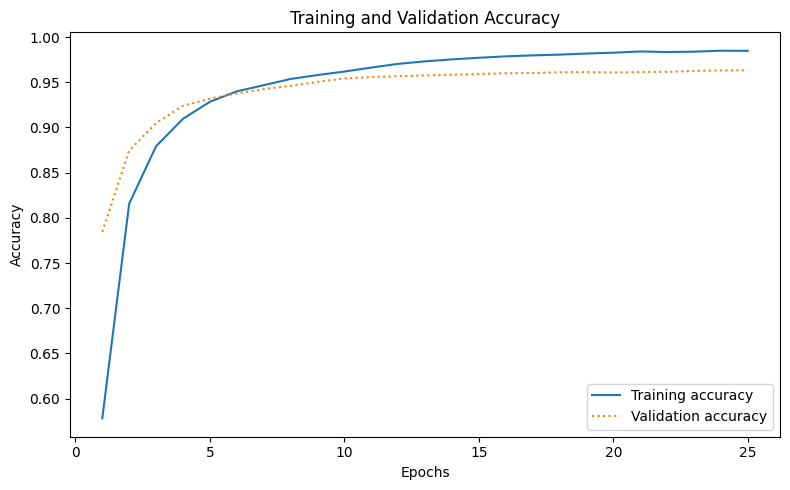

In [17]:
def plot_history(history):
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
    epochs = range(1, len(history['accuracy']) + 1)
    ax1.plot(epochs, history['accuracy'], '-', label='Training accuracy')
    ax1.plot(epochs, history['val_accuracy'], ':', label='Validation accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
plot_history(history)

In [29]:
correct = 0
total = 0
model.eval()
inputs = []
targets = []
predictions = []
with torch.no_grad():
    for encoder_input_batch, decoder_input_batch, target_batch in test_loader:
        encoder_input_batch = encoder_input_batch.to(device)
        decoder_input_batch = decoder_input_batch.to(device)
        target_batch = target_batch.to(device)
        output, attn_weights = model(encoder_input_batch, decoder_input_batch)
        output = output.view(-1, fr_vocab_size)
        
        original_shape = target_batch.shape
        target_batch_flat = target_batch.view(-1)
        _, predicted = torch.max(output, 1)
        mask = (target_batch_flat != 0)  # Ignore padding
        correct += ((predicted == target_batch_flat) & mask).sum().item()
        total += mask.sum().item()
        
        predicted = predicted.view(original_shape)
        
        # Convert tensors to lists or numpy arrays before extending
        inputs.append(encoder_input_batch.cpu().numpy())
        targets.append(target_batch.cpu().numpy())
        predictions.append(predicted.cpu().numpy())

# After the loop, concatenate all the collected batches
inputs = np.concatenate(inputs, axis=0)
targets = np.concatenate(targets, axis=0)
predictions = np.concatenate(predictions, axis=0)

test_accuracy = correct / total
print(f"Test Accuracy : {test_accuracy:.4f}")

Test Accuracy : 0.9637


In [30]:
random_sentence = np.random.choice(list(range(len(inputs))))
decoded_en_sentence = decode_sequence(inputs[random_sentence], entokenizer)
decoded_fr_sentence = decode_sequence(targets[random_sentence], frtokenizer)
decoded_output = decode_sequence(predictions[random_sentence], frtokenizer)

print(f'Decoded English sentence: {decoded_en_sentence}')
print(f'Decoded French sentence: {decoded_fr_sentence}')
print(f'Decoded predicted French sentence: {decoded_output}')

Decoded English sentence: tom could do that <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Decoded French sentence: tom pourrait faire cela [end] <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Decoded predicted French sentence: tom pourrait faire cela [end] [end] [end] [end] [end] [end] [end] [end] [end] [end] [end] [end]


## Question 2: BERT for sentiment analysis

For the last problem, we are going to learn how to use the huggingface library to train a simple BERT classifier for sentiment analysis.

We will use the IMDB dataset. You can find the dataset from huggingface using the following command:

```
from datasets import load_dataset
imdb = load_dataset("imdb")
```
To access BERT, use
```
from transformers import BertForSequenceClassification
#load pre-trained BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)
```
To reduce training complexity, you can choose to freeze the weight of the pretrained BERT model and only train the classifier. The classifier should have a minimum of 3 layers.
You might find https://huggingface.co/blog/sentiment-analysis-python and https://github.com/baotramduong/Twitter-Sentiment-Analysis-with-Deep-Learning-using-BERT/blob/main/Notebook.ipynb helpful.

